# Mushroom classification

### Is the mushroom edible or poisonous 
We analyse some mushrooms characteristics that could help classify a mushroom as edible or poisonous. The steps of the analysis are:
1. Import data and explore its characteristics -> a priori indetification of important variables
2. Addapt dataset based on findings, create training and testing sets and test the best model fit
3. Identify what attributes have the greater impact in the mushoom classification

### Imports

In [1]:
import numpy as np # math
import pandas as pd # display tables


import matplotlib.pyplot as plt ### plotting
%matplotlib inline
import seaborn as sns

from sklearn.preprocessing import LabelEncoder ### data pre-processing
from sklearn.preprocessing import LabelBinarizer

from sklearn.model_selection import cross_val_score, train_test_split ### tree classifier and evaluation
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import classification_report, confusion_matrix, precision_recall_curve, auc, roc_curve
from sklearn.tree import DecisionTreeClassifier, export_graphviz
import graphviz


### Dataset characteristics

In [2]:
data = '/Users/sara/BioCompu/Knowledge_representation/Challenge/mushrooms.csv'

In [3]:
df = pd.read_table(data, delimiter=',', header='infer')
df.head()

,class,cap-shape,cap-surface,cap-color,bruises,odor,gill-attachment,gill-spacing,gill-size,gill-color,...,stalk-surface-below-ring,stalk-color-above-ring,stalk-color-below-ring,veil-type,veil-color,ring-number,ring-type,spore-print-color,population,habitat
0,p,x,s,n,t,p,f,c,n,k,...,s,w,w,p,w,o,p,k,s,u
1,e,x,s,y,t,a,f,c,b,k,...,s,w,w,p,w,o,p,n,n,g
2,e,b,s,w,t,l,f,c,b,n,...,s,w,w,p,w,o,p,n,n,m
3,p,x,y,w,t,p,f,c,n,n,...,s,w,w,p,w,o,p,k,s,u
4,e,x,s,g,f,n,f,w,b,k,...,s,w,w,p,w,o,e,n,a,g


<br><br>The data is categorical, and most learning algorithms prefer ordinal (and discrete) data. For this reason, we will transform the data. We have two alternatives here:
1. Use __LabelEncoder__: coverts each categorical feature into an integrer. The problem with this methodology is that there is an implicit relation between the integrer values; for example, cap-shape has the values [bell=b,conical=c,convex=x,flat=f, knobbed=k,sunken=s] and LabelEncoder will return [1,2,3,4] which will imply that 'sunken' will be closer (more similar) to knobbed than to 'bell'. For this reason, this method is not recomended when there are more than 2 classes in each attribute like our case. On the other hand, using this values we can see the correlation between features and find those which have the highest impact in the classification.
2. Use __OneHotEncoder__: coverts the categorical features into 'dummies', binary features with no infered characteristics. The flaw in this transformation is that it introduces more columns and for large datasets this might be a problem. This is not our case so that is not a reason to reject one-hot encoding.
  
Depending on the classification algorithm that we use, we will choose one option or the other.
<br><br><br>
Before doing that, we will further observe the data in the kaggle dataset information (https://www.kaggle.com/uciml/mushroom-classification). <br>There are some interesting observations:  
   - The data is balanced: 52% edible and 48% poisonous. This are good news, because if the data was not balanced, it would have been necesary to implement advanced sampling methods like minority oversampling.
   - The attribute 'stalk-root' has an unknown category '?'. In order to avoid creating artifacts in the analysis, we should delete all columns that contain '?' value.
   - The attribute 'veil-type' is only associated with the class 'poisonous' and therefore is also not useful. We can remove it from the analysis.
<br><br><br>

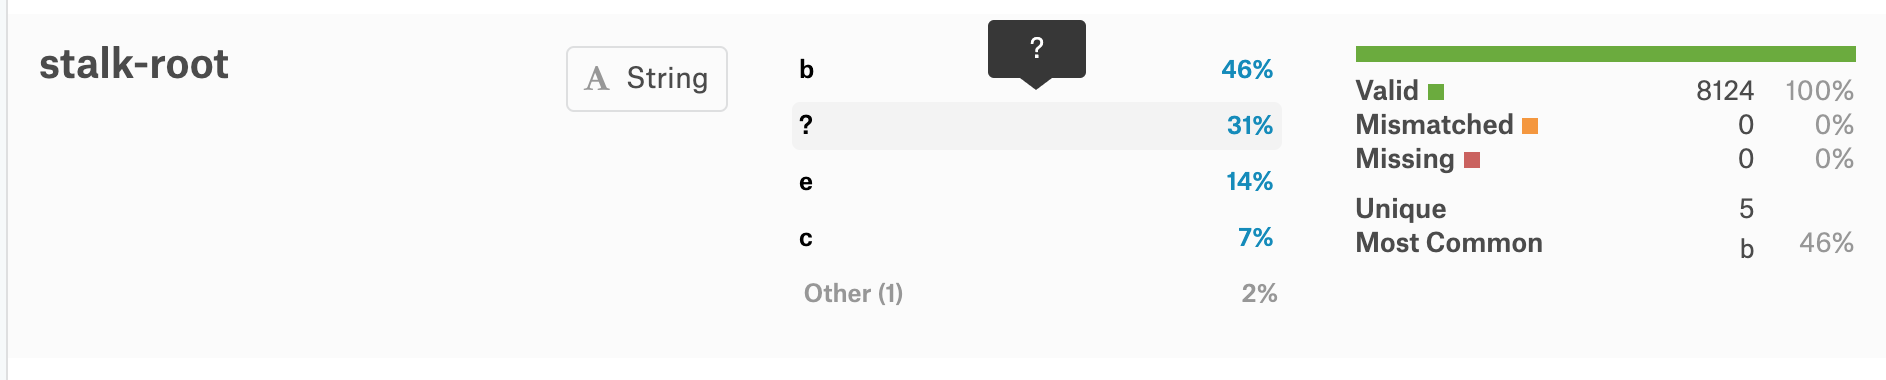

In [4]:
from IPython.display import Image
Image(filename='/Users/sara/BioCompu/Knowledge_representation/Challenge/other/stalk-root_data.png') 

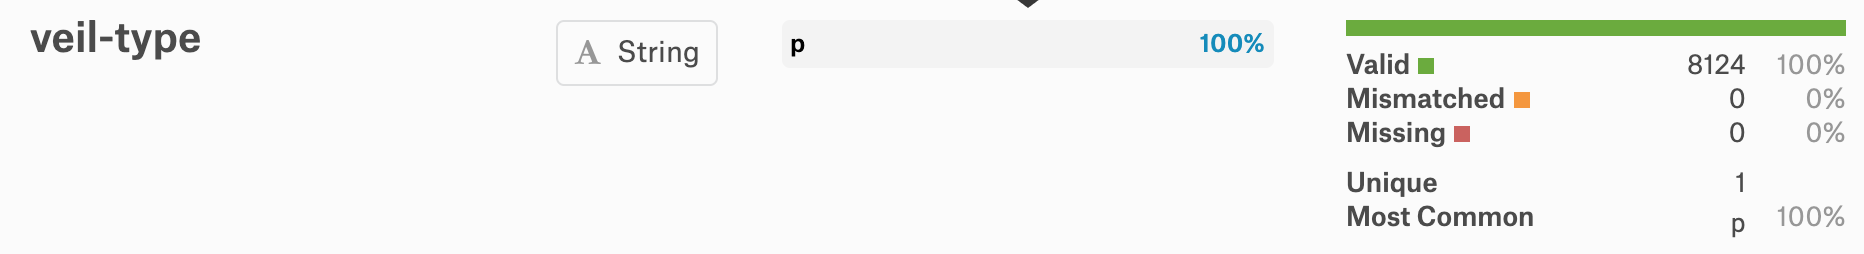

In [5]:
from IPython.display import Image
Image(filename='/Users/sara/BioCompu/Knowledge_representation/Challenge/other/veil_p.png') 

<br><br>
## Plot data characteristics
We will see the data characteristics by plotting the variance and the correlation between attributes, which will provide useful information to identify the attributes that are more likely to have greater weight in the classification. To do so we need to transform the data with LabelEncoader because the analyses requiere integrer values.  
  
<br><br>

In [6]:
# TRANSFORM DATA WITH LabelEncoder
labelencoder=LabelEncoder()
for column in df.columns:
    df[column] = labelencoder.fit_transform(df[column])
df.head()

,class,cap-shape,cap-surface,cap-color,bruises,odor,gill-attachment,gill-spacing,gill-size,gill-color,...,stalk-surface-below-ring,stalk-color-above-ring,stalk-color-below-ring,veil-type,veil-color,ring-number,ring-type,spore-print-color,population,habitat
0,1,5,2,4,1,6,1,0,1,4,...,2,7,7,0,2,1,4,2,3,5
1,0,5,2,9,1,0,1,0,0,4,...,2,7,7,0,2,1,4,3,2,1
2,0,0,2,8,1,3,1,0,0,5,...,2,7,7,0,2,1,4,3,2,3
3,1,5,3,8,1,6,1,0,1,5,...,2,7,7,0,2,1,4,2,3,5
4,0,5,2,3,0,5,1,1,0,4,...,2,7,7,0,2,1,0,3,0,1


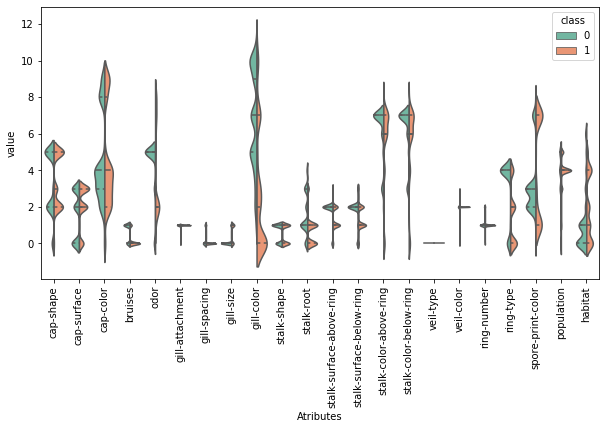

In [7]:
# VARIANCE PLOT
    
dif = pd.melt(df, "class", var_name="Atributes") #differenciate class col in the df 
fig, ax = plt.subplots(figsize=(10,5)) #set the plot frame
p = sns.violinplot(ax = ax, x="Atributes", y="value", hue="class", split = True, data=dif, inner = 'quartile', palette = 'Set2')
work_df = df.drop(["class"],axis = 1) # get the df without the class col
p.set_xticklabels(rotation = 90, labels = list(work_df.columns)); # adding ';' prevents from text info to be outputted


There are a few interesting things to see in this plot:
- As expected, 'veil-type' has no variance because all values belong to the poisonous class
- There are 6 attributes with high variance (like 'gill-color') and we can expect those to be the most relevant features for the classification. We will now see if those also have a high correlation to check this hypothesis.

<br><br>
#### Plot correlation between variables

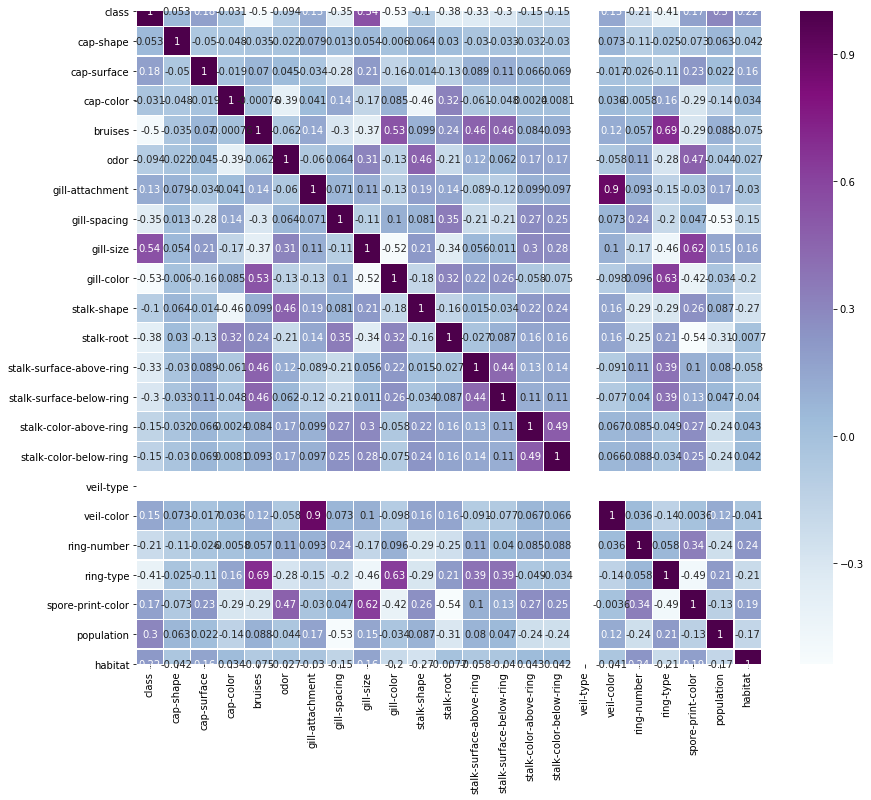

In [8]:
plt.figure(figsize=(14,12)) #set the plot frame
sns.heatmap(df.corr(),linewidths=.1,cmap="BuPu", annot=True) ; #plot correlation

From this plot we can see: 
- Again, 'veil-type' has no relevant information. It is all white because the correlation is 0
- There are not many attributes that have a high correlation, meaning that if we wanted to get a subset of attributes to do the classification, we would still need a high number of attributes (3-4 would not be enough)
- The attibutes with correlations closer to |1| are probably the ones with the highest impact in the classification